# High-Dimensional Diffusion MRI Reconstruction Totorial

### Introduction:

  * High-dimensional MRI (HD-MRI) refers to the acquisition of more than 2D image data. Typical examples are dynamic MRI, quantitative parameter mapping, and diffusion MRI.

  * This notebook 

    1. extends the linear operator abstraction framework in [SigPy](https://github.com/mikgroup/sigpy) to achieve HD-MRI reconstruction;
    2. utilizes data acquired from an advanced high-resolution diffusion MRI pulse sequence at 7 T, building upon multi-shot echo-planar imaging (EPI).
    3. demonstrates a comprehensive forward modeling comprising **shot-to-shot phase variation**, based on which [MUSE](https://doi.org/10.1016/j.neuroimage.2013.01.038) reconstruction is conducted;
    3. constrcuts HD regularization terms, e.g. overlapping locally low rank (LLR), for HD-MRI reconstruction.

### Authors:

  * Zhengguo Tan <zhengguo.tan@gmail.com>
  * Patrick A Liebig <patrick.liebig@siemens-healthineers.com>
  * Robin M Heidemann <robin.heidemann@siemens-healthineers.com>
  * Fredrik B Laun <Frederik.Laun@uk-erlangen.de>
  * Florian Knoll <florian.knoll@fau.de>

# 1. Setup

## Connect to a GPU on `Google Colab`

  * Go to `Edit` > `Notebook settings` > select `GPU` > click `Save`;
  * Now we can verify that we allocate a GPU for this notebook.

In [ ]:
!nvidia-smi
!nvcc --version

Mon May 29 14:32:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install SigPy

  * The original [SigPy](https://github.com/mikgroup/sigpy.git) was fored for the development of HD-MRI reconstruction and is available here: https://github.com/ZhengguoTan/sigpy.git

In [ ]:
!git clone https://github.com/ZhengguoTan/sigpy.git

Cloning into 'sigpy'...
remote: Enumerating objects: 6105, done.
remote: Counting objects: 100% (641/641), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 6105 (delta 424), reused 555 (delta 392), pack-reused 5464
Receiving objects: 100% (6105/6105), 3.73 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (4444/4444), done.


In [ ]:
%cd /content/sigpy
!git log -1

/content/sigpy
commit 0771b52d0ef9971b2b834fe992db608057909235 (HEAD -> master, origin/master, origin/HEAD)
Author: Zhengguo Tan <zhengguo.tan@gmail.com>
Date:   Mon Dec 26 13:51:41 2022 +0100

    add keepdims option in Sum and Tile linop


In [ ]:
!pip install -e /content/sigpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/sigpy
  Preparing metadata (setup.py) ... done
  Running setup.py develop for sigpy


# 2. Build a Shot-Phase-Informed Parallel Imaging Reconstruction

(1) Read in data

Data  | Diffusion encodings | Shots | Coils | Slices | Phase encoding | Readout 
--    | --                  | --    | --    | --     | --             | -- 
imaging echo | 4  | 5 | 32 | 1 | 440 | 440 
shot phase | 4  | 5 | 32 | 2 | 440 | 440
coil sensitivity maps | - | - | 32 | 2 | 440 | 440


# 4. LLR Regularization

The core concept of LLR is to enforce low rankness in local patches.

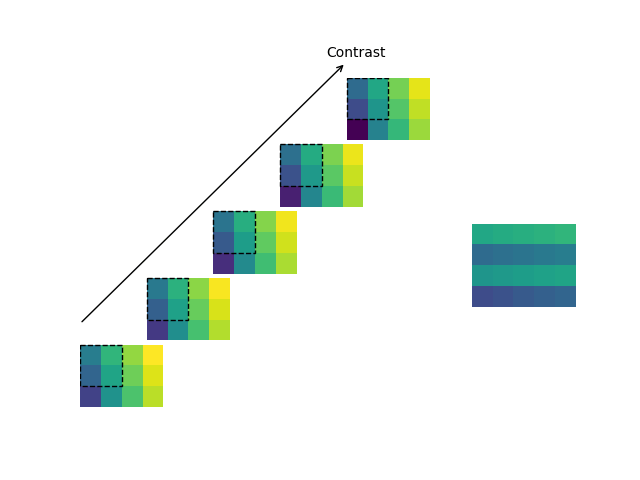

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import imageio.v2 as imageio

blocks = [2, 2]
strides = [1, 1]

sepa = 3.2

nrows = 3
ncols = 4
nvars = 5
Z = np.arange(nrows * ncols * nvars).reshape(ncols, nrows, nvars) ** 0.6
Z = Z.transpose()
x = np.arange(ncols + 1)
y = np.arange(nrows + 1)


len_x = (ncols - blocks[-1] + strides[-1]) // strides[-1]
len_y = (ncols - blocks[-2] + strides[-2]) // strides[-2]

fig_cnt = 0
frames = []

for ind_y in range(len_y, 1, -1):
  for ind_x in range(0, len_x, 1):

    fig, ax = plt.subplots()

    # plot arrays
    for ind in range(nvars):
      Z1 = Z[ind, ...]
      ax.pcolormesh(x-sepa*ind, y-sepa*ind, Z1, shading='flat', 
                    vmin=Z.min(), vmax=Z.max())
    
    # draw arrow
    offset = 4
    ax.annotate('Contrast', 
                xytext=(x[0] - 1, y[0] + offset),
                xy=(x[0] - sepa*(nvars-1), y[0] - sepa*(nvars-1) + offset),
                arrowprops=(dict(arrowstyle='<-')))

    # plot blocks
    for ind_z in range(nvars):

      rect = Rectangle((ind_x - sepa*ind_z, ind_y-sepa*ind_z), 
                       blocks[-1], -blocks[-2],
                       facecolor='none', edgecolor='k', linestyle='--')
      ax.add_patch(rect)

    # plot flattened blocks
    Z2 = Z[:, ind_y-blocks[-2] : ind_y, ind_x : ind_x+blocks[-1]]
    Z2 = np.reshape(Z2, [nvars, -1]).transpose()

    Z2_shape = Z2.shape

    ax.pcolormesh(np.arange(Z2_shape[-1]+1)+6, np.arange(Z2_shape[-2]+1)-8, Z2, 
                  shading='flat', vmin=Z.min(), vmax=Z.max())

    ax.set_aspect('equal')
    ax.set_axis_off()

    fig_name = f'/content/frame_{fig_cnt}.png'
    plt.savefig(fig_name)

    fig_cnt = fig_cnt + 1

    plt.close()
    
    # Append the current image to the list of frames
    frames.append(imageio.imread(fig_name))


# Save the frames as a GIF
output_file = '/content/llr_animation.gif'
# Adjust the duration between frames as needed
imageio.mimsave(output_file, frames, duration=1)

# display gif
from IPython.display import Image
Image(open(output_file, 'rb').read())

Overlapping blocks lead to duplicate values in the adjoint operator.

In [ ]:
import numpy as np
import sigpy as sp
from sigpy import linop

x = np.arange(60).reshape([5, 3, 4])

T = linop.ArrayToBlocks(x.shape, blk_shape=(2, 2), blk_strides=(1, 1))

blocks = T * x

y = T.H * T * x

print('>>>>> \n3D array: ')
print(x)

print('>>>>> \nblocks shape: ')
print(blocks.shape)

print('>>>>> \ny: ')
print(y)

>>>>> 
3D array: 
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]

 [[24 25 26 27]
  [28 29 30 31]
  [32 33 34 35]]

 [[36 37 38 39]
  [40 41 42 43]
  [44 45 46 47]]

 [[48 49 50 51]
  [52 53 54 55]
  [56 57 58 59]]]
>>>>> 
blocks shape: 
(5, 2, 3, 2, 2)
>>>>> 
y: 
[[[  0   2   4   3]
  [  8  20  24  14]
  [  8  18  20  11]]

 [[ 12  26  28  15]
  [ 32  68  72  38]
  [ 20  42  44  23]]

 [[ 24  50  52  27]
  [ 56 116 120  62]
  [ 32  66  68  35]]

 [[ 36  74  76  39]
  [ 80 164 168  86]
  [ 44  90  92  47]]

 [[ 48  98 100  51]
  [104 212 216 110]
  [ 56 114 116  59]]]


We can fix this problem using a scaling matrix

In [ ]:
# now we compute the scaling matrix to correct the overlapping problem
I = np.ones_like(x)
S = T.H * T * I

# now we can apply this caling matrix to correct for y
y_corr = (T.H * T * x) / S

print('>>>>> \n3D array: ')
print(x)

print('>>>>> \ny_corr: ')
print(y_corr)

>>>>> 
3D array: 
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]

 [[24 25 26 27]
  [28 29 30 31]
  [32 33 34 35]]

 [[36 37 38 39]
  [40 41 42 43]
  [44 45 46 47]]

 [[48 49 50 51]
  [52 53 54 55]
  [56 57 58 59]]]
>>>>> 
y_corr: 
[[[ 0.  1.  2.  3.]
  [ 4.  5.  6.  7.]
  [ 8.  9. 10. 11.]]

 [[12. 13. 14. 15.]
  [16. 17. 18. 19.]
  [20. 21. 22. 23.]]

 [[24. 25. 26. 27.]
  [28. 29. 30. 31.]
  [32. 33. 34. 35.]]

 [[36. 37. 38. 39.]
  [40. 41. 42. 43.]
  [44. 45. 46. 47.]]

 [[48. 49. 50. 51.]
  [52. 53. 54. 55.]
  [56. 57. 58. 59.]]]


# 5. Diffusion MRI Reconstruction with Spatial-Diffusion LLR Regularization

**Thank you for your attention!**